# Circuit Composition

We analyze circuit composition of the mouse SSCx circuit.

In [2]:
#top level imports
import os
from collections import OrderedDict
import pandas as pd
from tqdm import tqdm
from dmt.tk.plotting import Bars, LinePlot, Crosses, MultiPlot
from dmt.data.observation import measurement
from dmt.tk.phenomenon import Phenomenon
from dmt.tk.parameters import Parameters
from neuro_dmt import terminology
from dmt.tk.utils import datasets
from dmt.data.observation import SampleMeasurement, Summary
from neuro_dmt.utils.geometry.roi import Cuboid
from neuro_dmt.analysis.reporting import CircuitProvenance, CheetahReporter
from neuro_dmt.analysis.circuit import BrainCircuitAnalysis

use_mock = False

## Mock Circuit

We will use the mock circuit to develop our analyses.

In [3]:
#mock circuit
from neuro_dmt.library.models.mock.circuit.model import\
    MockCircuitModel
from neuro_dmt.library.models.mock.circuit.test.mock_circuit_light\
    import circuit_composition, circuit_connectivity

def circuit_mock():
    return MockCircuitModel(
        circuit_composition,
        circuit_connectivity,
        label="SSCxMockCircuit")

## Mouse SSCx Circuit

We will also analyze a model of the mouse SSCx circuit.

In [4]:
path_circuit = os.path.join(
    "/gpfs/bbp.cscs.ch/project/proj66/circuits/O1/20200330/sonata")

## SONATA circuit model and adapter

We have defined classes to work with SONATA circutis.

In [5]:
from neuro_dmt.library.models.sonata.circuit.model import\
    SonataCircuitModel
from neuro_dmt.library.models.sonata.circuit.adapter import\
    SonataCircuitAdapter

circuit_model =\
    circuit_mock() if use_mock else\
    SonataCircuitModel(path_circuit_data=path_circuit)
adapter = SonataCircuitAdapter()

## Reporter

Our analyses will produce a report object that can be posted as HTMLs using a
reporter.

In [6]:
from neuro_dmt.analysis.reporting import CheetahReporter
reporter = CheetahReporter(
    path_output_folder=os.path.join(os.getcwd(), "analyses"))

We will analyze one phenoemenon at a time.

In [7]:
phenomennon = OrderedDict()

# Input and Reference Data

We have used data provided by the DeFelipe lab for building the mouse SSCX 
circuit. This data is for the thickness and layer composition.

In [8]:
class LayerThicknessMeasurement(SampleMeasurement):
    """
    Measurement of layer thicknesses.
    """
    phenomenon = Phenomenon(
        "thickness",
        description="Thickness of layers.",
        group="Composition")
    parameters = OrderedDict(
        layer="Cortical layer whose thickness was measured.")
    
    
class ByLayerCellDensityMeasurement(SampleMeasurement):
    """
    Measurement of cell density, by (cortical) layer.
    """
    phenomenon = Phenomenon(
        "Cell Density",
        description="Count of cells per unit volume.",
        group="Composition")
    parameters = OrderedDict(
        layer="Cortical layer where to count the cells in.")
    
    
class ByLayerInhibitoryCellFractionMeasurement(SampleMeasurement):
    """
    Measurement of inhibitory cell fraction, by cortical layer.
    """
    phenomenon = Phenomenon(
        "Inhibitory Cell Fraction",
        description = "Fraction of inhibitory cells.",
        group="Composition"
    )
    parameters = OrderedDict(
        layer="Cortical layer where the inhibitory cell fraction was measured"
    )

In [9]:
path_mouse_data =\
    os.path.join(
        os.environ["DMTPATH"],
        "neuro_dmt/library/data/sscx_mouse/composition")
defelipe_2018_thickness_dataset =\
    datasets.load(
        os.path.join(path_mouse_data, "layer_thickness"),
        "DeFelipe20180212")
thickness_defelipe_2018 =\
    Summary(LayerThicknessMeasurement)(
        label=defelipe_2018_thickness_dataset["short_name"],
        object_of_observation="Somatosensory cortexes of a population of mice",
        procedure=defelipe_2018_thickness_dataset["what"],
        provenance="DeFelipe Lab, 2018",
        citation=defelipe_2018_thickness_dataset["citation"],
        uri=defelipe_2018_thickness_dataset["uri"],
        data=pd.DataFrame(
            [[density_mean, density_std]
             for density_mean, density_std in zip(
                 defelipe_2018_thickness_dataset["means"],
                 defelipe_2018_thickness_dataset["errors"])],
            columns=pd.MultiIndex.from_tuples([
                ("thickness", "mean"),
                ("thickness", "std")])
        ).assign(layer=[1,2,3,4,5,6]))

In [10]:
defelipe_2018_cell_density_dataset =\
    datasets.load(
        os.path.join(path_mouse_data, "cell_density"),
        "Keller2018Feb14")
cell_density_defelipe_2018 =\
    Summary(ByLayerCellDensityMeasurement)(
        label=defelipe_2018_cell_density_dataset["short_name"],
        object_of_observation="Somatosensory cortexes of a population of mice",
        procedure=defelipe_2018_cell_density_dataset["what"],
        provenance="DeFelipe Lab, 2018",
        citation=defelipe_2018_cell_density_dataset["citation"],
        uri=defelipe_2018_cell_density_dataset["uri"],
        data=pd.DataFrame(
            [[1.e3 * density_mean, 1.e3 * density_std]
             for density_mean, density_std in zip(
                 defelipe_2018_cell_density_dataset["density_means"],
                 defelipe_2018_cell_density_dataset["density_stds"])],
            columns=pd.MultiIndex.from_tuples([
                ("cell_density", "mean"),
                ("cell_density", "std")])
    ).assign(layer=[1,2,3,4,5,6]))

In [11]:
defelipe_2018_inhibitory_ratio_dataset =\
    datasets.load(
        os.path.join(path_mouse_data, "cell_ratio"),
        "LeFort2009")
count_all =\
    np.array(
        defelipe_2018_inhibitory_ratio_dataset["count_all"])
count_inh =\
    np.array(
        defelipe_2018_inhibitory_ratio_dataset["count_inh"])

inh_cell_ratio_lefort_2009 =\
    Summary(ByLayerInhibitoryCellFractionMeasurement)(
        label=defelipe_2018_inhibitory_ratio_dataset["short_name"],
        object_of_observation="Somatosensory cortexes of a population of mice",
        procedure=defelipe_2018_inhibitory_ratio_dataset["what"],
        citation=defelipe_2018_inhibitory_ratio_dataset["citation"],
        uri=defelipe_2018_inhibitory_ratio_dataset["uri"],
        data=pd.DataFrame({
            ("inhibitory_cell_fraction", "mean"): count_inh / count_all,
            ("inhibitory_cell_fraction", "std"):  1./np.sqrt(count_all)}
        ).assign(layer=[1,2,3,4,5,6]))

# Circuit Structure

The mouse SSCx scaffold circuit models a column. 
Here we characterize the physical structure of the model.

We will collect the methods needed to analyze a circuit in an adapter-interface.

In [12]:
from dmt.model.interface import Interface
class CompositionAdapterInterface(Interface):
    pass

In [13]:
def get_layers(adapter, circuit_model):
    return pd.DataFrame(
            adapter.get_cells(circuit_model).layer.unique(),
            columns=["layer"])

def measurement_thickness(adapter, circuit_model, layer, **kwargs):
    y = adapter.get_cells(circuit_model, layer=layer).y
    return y.max() - y.min()

analysis_layer_thickness =\
    BrainCircuitAnalysis(
        phenomenon=Phenomenon(
            "thickness", 
            description="Thickness of layers.",
            group="Composition"),
        introduction="""
            Thickness of layers measured in each region modeled in the circuit.
            """,
        methods="""
            Thickness of layers were measured using cell positions.
            """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_layers),
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        sample_measurement=measurement_thickness,
        plotter=Bars(xvar="layer",
                     xlabel="Layer",
                     yvar="thickness",
                     ylabel="Thickness",
                     gvar="dataset"))

## Layer Thickness



We have used the data from DeFelipe's lab as inputs for layer thickness
and cell density. To use this data for validation we load it.

100%|██████████| 6/6 [00:00<00:00, 133.11it/s]
/home/muchu/.vmgr_repo/py38/lib/python3.8/site-packages/neuro_dmt/analysis/circuit/__init__.py Logger
INFO@<2020-04-09 12:19:14>                                                      

                Could not retrieve citations from reference data of type <class 'dict'>.
                


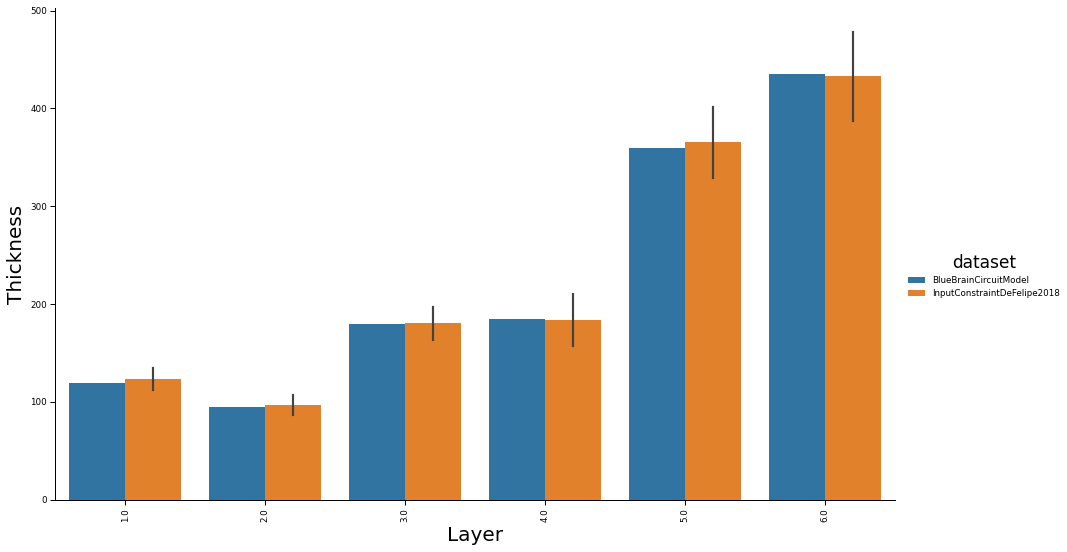

In [14]:
report_thickness =\
    analysis_layer_thickness(
        adapter,
        circuit_model,
        reference_data={
            "InputConstraintDeFelipe2018": thickness_defelipe_2018.samples(100)})

# Circuit Composition

The circuit models we analyze here are structured in layers, 
and are composed of cells and connections running between them.
We analyze the composition of circuit.

## Cell Density

We analyze several aspects of cell density,
starting with testing that cell densities in the model are statistically
close to the input values.

In [15]:
def random_position(adapter, circuit_model, layer):
    """
    Get a random position located inside layer
    """
    cells = adapter.get_cells(circuit_model, layer=layer)
    return cells.sample(n=1)[["x", "y", "z"]].iloc[0].to_numpy(np.float)
    
def sample_cells(
        adapter,
        circuit_model,
        layer=None,
        depth=None,
        size_roi=50,
        **kwargs):
    """..."""
    if layer is None and depth is None:
        raise TypeError(
            """
            sample_cells(...) called with neither a value of layer or depth,
            Provide only one.
            """)
    if layer is not None and depth is not None:
        raise TypeError(
            """
            sample_cells(...) called with both layer and depth.
            Provide only one.
            """)
    if layer is None:
        layer = 4
    
    position = random_position(adapter, circuit_model, layer=layer)
    
    if depth is not None:
        position[1] = depth
                               
    return adapter.get_cells(
        circuit_model,
        roi=Cuboid(position - size_roi / 2.,
                   position + size_roi / 2.))
    
def measurement_cell_density(
        adapter,
        circuit_model,
        layer=None, depth=None,
        size_roi=50., **kwargs):
    """..."""
    cell_count =\
        sample_cells(
            adapter, circuit_model,
            size_roi=size_roi,
            layer=layer,
            depth=depth,
            **kwargs
        ).shape[0]
    return\
        1.e9 * cell_count / np.power(size_roi, 3)

analysis_cell_density =\
    BrainCircuitAnalysis(
        phenomenon=Phenomenon(
            "Cell Density", 
            description="Number of cells in a unit-volume",
            group="Composition"),
        introduction="""
            Cell density of each of the 6 layers in the SSCx.
            """,
        methods="""
            Cells were counted in random regions of interest (ROI).
            Several ROIs were sampled in each layer.
            Because only the center of an ROI was required to lie in 
            a layer, it may overlap a neighboring layer. For such ROIs
            cell density measurement would be an overlap of those of the two
            neighboring layers that the ROI covers.
            """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_layers),
        sampling_methodology=terminology.sampling_methodology.random,
        sample_measurement=measurement_cell_density,
        plotter=Bars(xvar="layer",
                     xlabel="Layer",
                     yvar="cell_density",
                     ylabel="Cell Density",
                     gvar="dataset"))

100%|██████████| 120/120 [00:01<00:00, 105.19it/s]
/home/muchu/.vmgr_repo/py38/lib/python3.8/site-packages/neuro_dmt/analysis/circuit/__init__.py Logger
INFO@<2020-04-09 12:19:14>                                                      

                Could not retrieve citations from reference data of type <class 'dict'>.
                


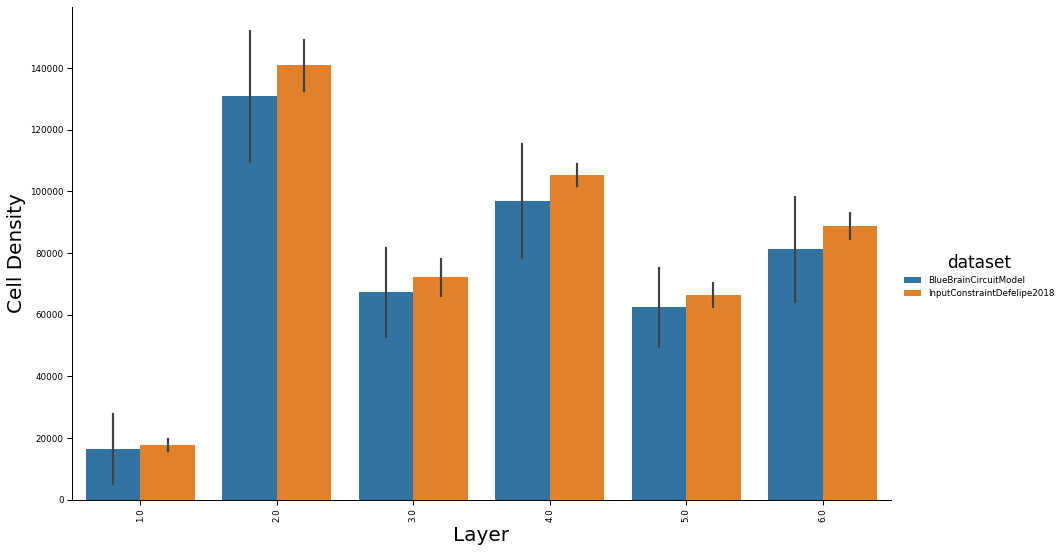

In [16]:
report_cell_density =\
    analysis_cell_density(
        adapter, circuit_model,
        reference_data={
            "InputConstraintDefelipe2018": cell_density_defelipe_2018.samples(100)})

## Inhibitory Cell Fraction

In [17]:
adapter.get_cells(circuit_model).head()

,etype,hypercolumn,layer,model_template,morph_class,morphology,mtype,region,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis,synapse_class,x,y,z,@dynamics:holding_current,@dynamics:threshold_current,gid
0,cIR,1,1,hoc:cIR_478110866,INT,sm081017b1-6_idC,L1_HAC,L1,0.000000,-0.984701,0.000000,INH,-150.000000,1257.500000,255.000000,-0.044269,0.065721,0
1,cADpyr,1,2,hoc:L23_cADpyr_382982932,PYR,dend-C170797A-P1_axon-sm100429b1-2_INT_idA_-_S...,L2_TPC:A,L2,0.000000,-0.866047,0.000000,EXC,-110.732701,1248.375645,210.166123,-0.062752,0.131318,1
2,cNAC,1,1,hoc:cNAC_484742372,INT,sm080903a1-3_idB_-_Scale_x1.000_y1.050_z1.000,L1_NGC-SA,L1,0.000000,-0.992833,0.000000,INH,-121.185072,1271.289097,307.401963,-0.000072,0.069347,2
3,cNAC,1,1,hoc:cNAC_484742372,INT,sm100330b1-2_idB_-_Scale_x1.000_y0.975_z1.000_...,L1_DAC,L1,-3.141593,1.059727,-3.141593,INH,-134.461444,1271.663199,230.256105,-0.000084,0.075412,3
4,cADpyr,1,2,hoc:L23_cADpyr_382982932,PYR,dend-C090905B_axon-rp120307_Deep_1_idB_-_Scale...,L2_TPC:B,L2,-3.141593,-0.617288,-3.141593,EXC,-112.162993,1241.696876,240.998738,-0.078791,0.177753,4


In [18]:
def measurement_inhibitory_fraction(
        adapter,
        circuit_model,
        layer,
        size_roi=50., **kwargs):
    """..."""
    cells = sample_cells(
        adapter, circuit_model, size_roi=size_roi, layer=layer, **kwargs)
    if cells.shape[0] == 0:
        return np.nan
    try:
        n_inh = cells.groupby("morph_class").agg("size").INT 
    except AttributeError:
        n_inh = 0.
    return n_inh / cells.shape[0]

analysis_inhibitory_fraction =\
    BrainCircuitAnalysis(
        phenomenon=Phenomenon(
            "Inhibitory Cell Fraction", 
            description="Fraction of cells that are inhibitory",
            group="Composition"),
        introduction="""
            Fraction of cells that are inhibitory, by layer.
            """,
        methods="""
            Cells were counted in random regions of interest (ROI).
            Several ROIs were sampled in each layer.
            Because only the center of an ROI was required to lie in 
            a layer, it may overlap a neighboring layer. For such ROIs
            cell density measurement would be an overlap of those of the two
            neighboring layers that the ROI covers.
            Number of cells that were inhibitory was divided by the total
            number of cells.
            """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_layers),
        sampling_methodology=terminology.sampling_methodology.random,
        sample_measurement=measurement_inhibitory_fraction,
        plotter=Bars(xvar="layer",
                     xlabel="Layer",
                     yvar="inhibitory_cell_fraction",
                     ylabel="Inhibutory Cell Fraction",
                     gvar="dataset"))


100%|██████████| 120/120 [00:01<00:00, 97.78it/s]
/home/muchu/.vmgr_repo/py38/lib/python3.8/site-packages/neuro_dmt/analysis/circuit/__init__.py Logger
INFO@<2020-04-09 12:19:14>                                                      

                Could not retrieve citations from reference data of type <class 'dict'>.
                


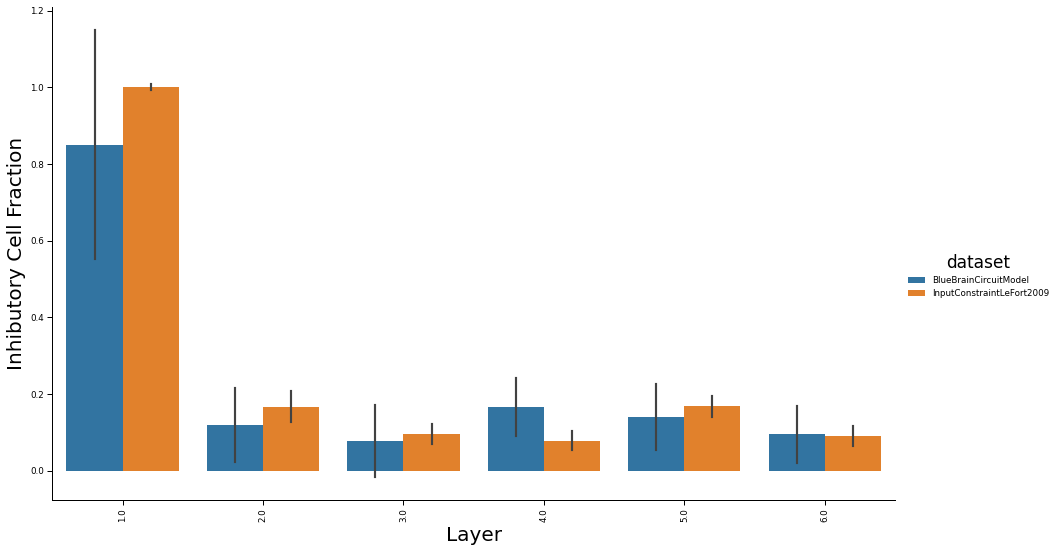

In [19]:
report_inhibitory_fraction =\
    analysis_inhibitory_fraction(
        adapter,
        circuit_model,
        reference_data={
            "InputConstraintLeFort2009": inh_cell_ratio_lefort_2009.samples(100)})

## Cell density by depth

How does cell density change with depth?

In [20]:
def get_depths(adapter, circuit_model, n_bins=20):
    """..."""
    cells = adapter.get_cells(circuit_model)
    depth_max = cells.y.max()
    depth_min = cells.y.min()
    return pd.DataFrame({
        "depth": np.linspace(depth_min, depth_max, n_bins)})
    
analysis_cell_density_by_depth =\
    BrainCircuitAnalysis(
        phenomenon=Phenomenon(
            "Cell Density", 
            description="Number of cells in a unit-volume",
            group="Composition"),
        introduction="""
            Cell density along cortical depth.
            """,
        methods="""
            Cells were counted in random regions of interest (ROI).
            Several ROIs were sampled for a 20 depth values.
            Because only the center of an ROI was required to lie in 
            a layer, it may overlap a neighboring layer. For such ROIs
            cell density measurement would be an overlap of those of the two
            neighboring layers that the ROI covers.
            """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_depths),
        sampling_methodology=terminology.sampling_methodology.random,
        sample_measurement=measurement_cell_density,
        plotter=LinePlot(xvar="depth",
                         xlabel="Cortical Depth",
                         yvar="cell_density",
                         ylabel="Cell Density"))

100%|██████████| 400/400 [00:03<00:00, 106.87it/s]


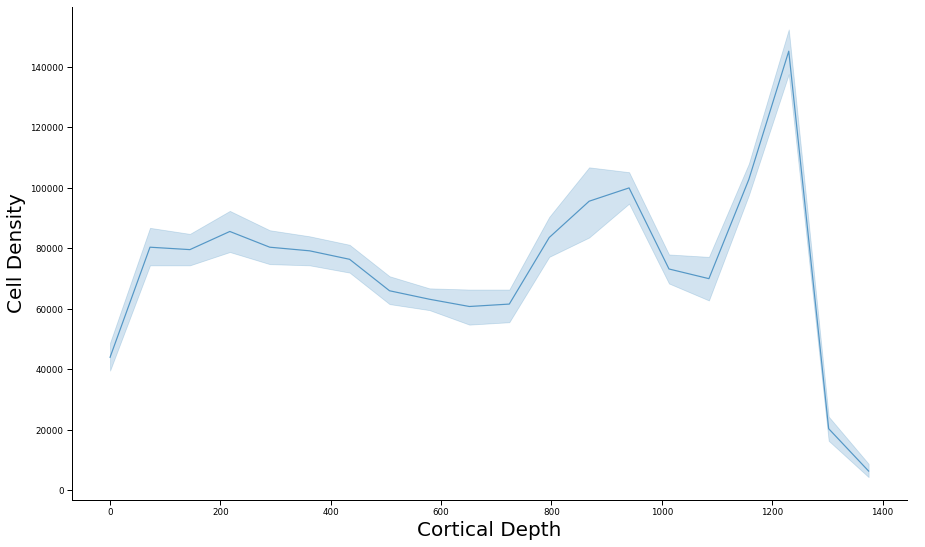

In [21]:
report_cell_density_by_depth =\
    analysis_cell_density_by_depth(
        adapter, circuit_model)

## Cell Density by mtype

What is density of cells of a given mtype?

In [22]:
def measurement_mtype_cell_density(
        adapter,
        circuit_model,
        layer=None, depth=None,
        size_roi=50., **kwargs):
    """..."""
    cells =\
        sample_cells(
            adapter, circuit_model,
            size_roi=size_roi,
            layer=layer,
            depth=depth,
            **kwargs)
    return cells.groupby(["mtype", "morph_class"])\
                .agg("size")\
                .rename("cell_density")\
                .apply(lambda density: 1.e9 * density / np.power(size_roi, 3))
    

analysis_mtype_cell_density =\
    BrainCircuitAnalysis(
        phenomenon=Phenomenon(
            "Cell Density", 
            description="Number of cells in a unit-volume",
            group="Composition"),
        introduction="""
            Cell density along cortical depth, for each mtype.
            """,
        methods="""
            Cells were counted in random regions of interest (ROI).
            Several ROIs were sampled in each layer.
            Because only the center of an ROI was required to lie in 
            a layer, it may overlap a neighboring layer. For such ROIs
            cell density measurement would be an overlap of those of the two
            neighboring layers that the ROI covers.
            """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_layers),
        sampling_methodology=terminology.sampling_methodology.random,
        sample_measurement=measurement_mtype_cell_density,
        measurement_collection=measurement.collection.series_type,
        plotter=MultiPlot(
            mvar="layer",
            plotter=Bars(
                xvar="mtype",
                xlabel="Cortical Layer",
                yvar="cell_density",
                ylabel="Cell Density")))

100%|██████████| 120/120 [00:01<00:00, 60.62it/s]


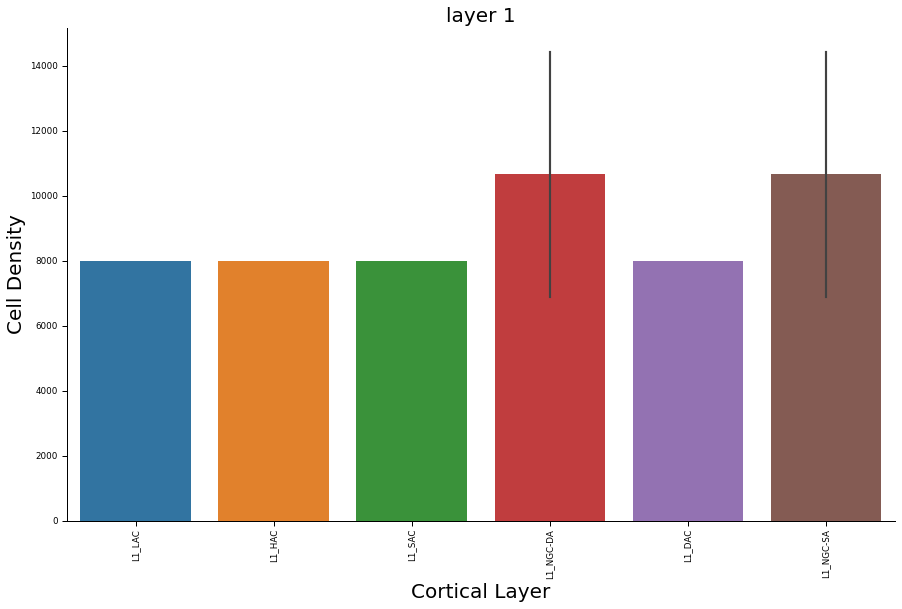

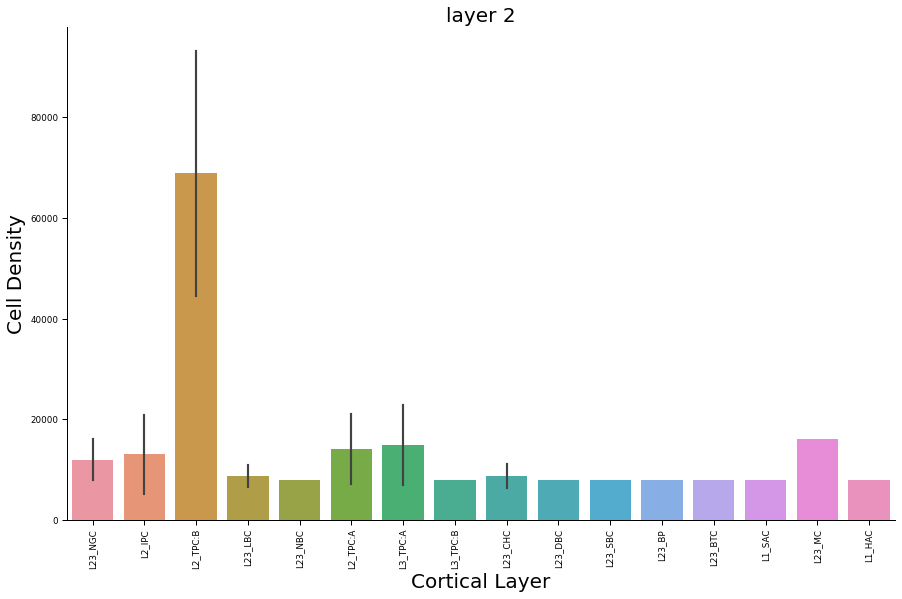

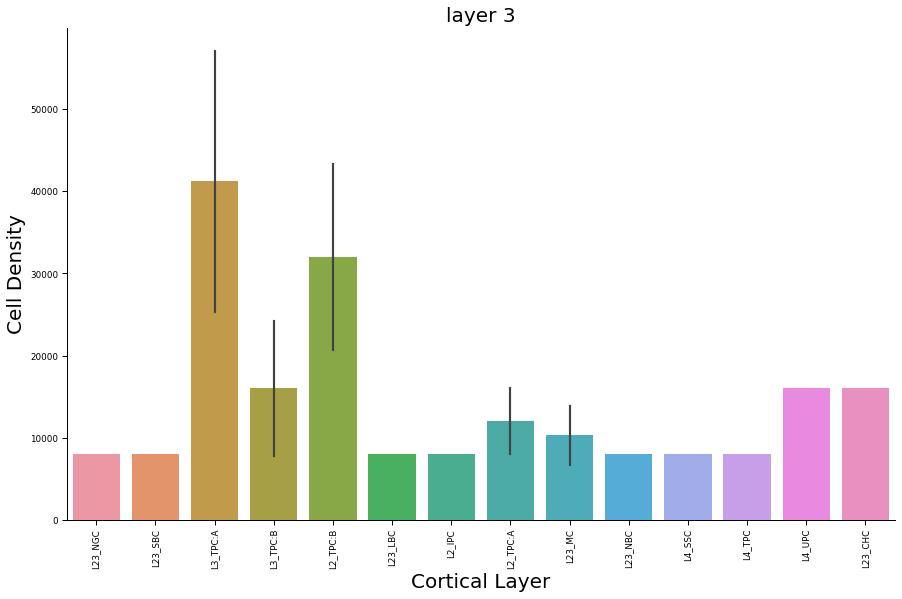

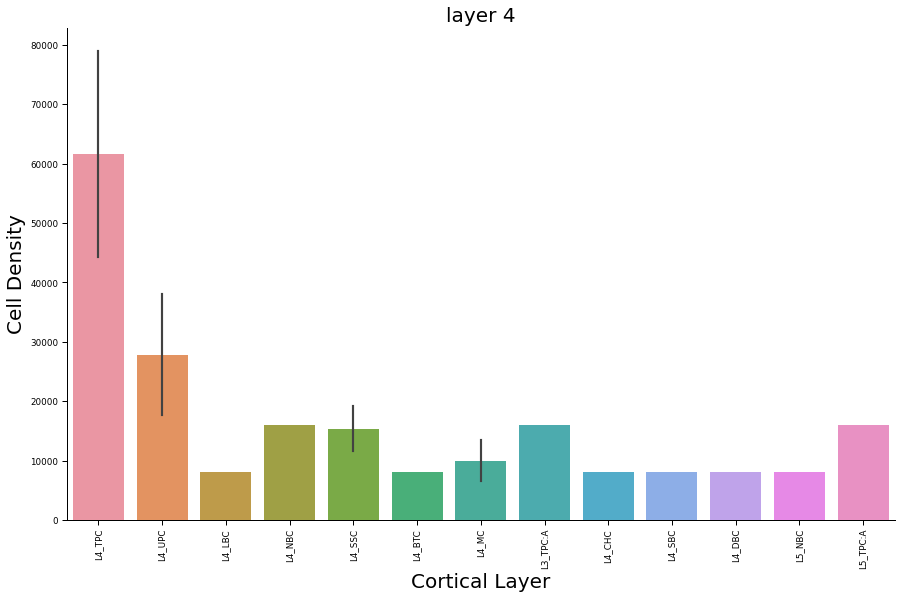

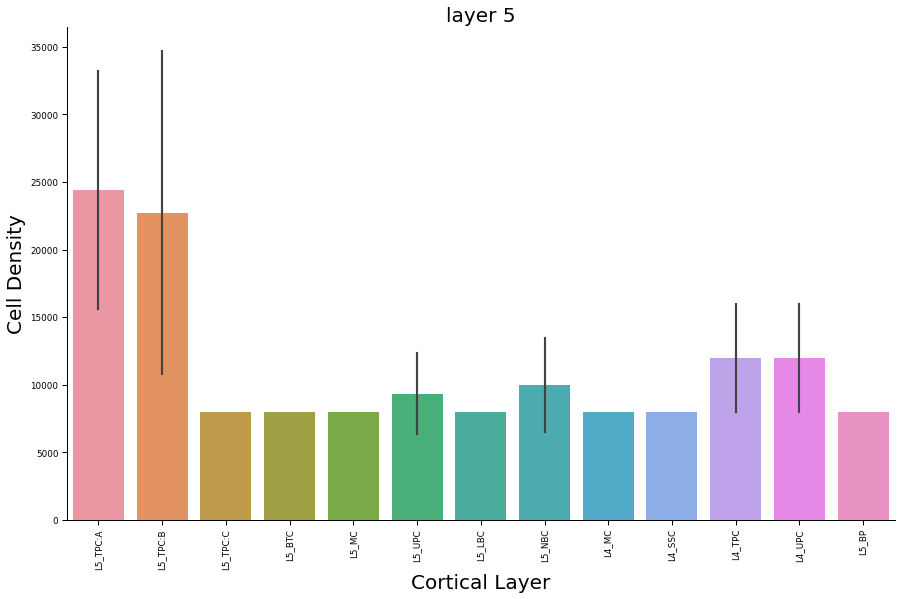

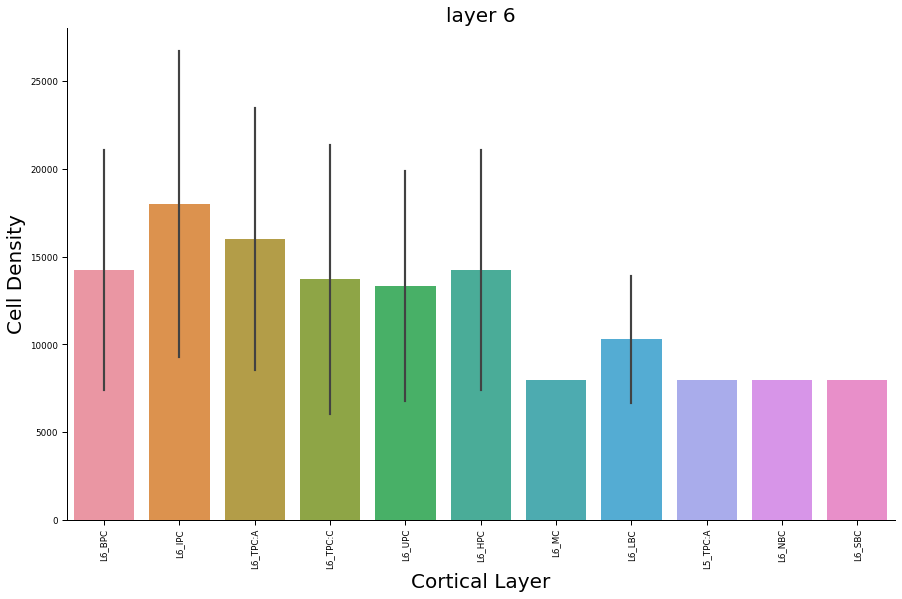

In [23]:
report_mtype_cell_density =\
    analysis_mtype_cell_density(adapter, circuit_model)